In [1]:
#Import required libraries
import os
import argparse
import networkx as nx
import math        
import numpy as np
import helper
import astar
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import csv
from random import randint, random, seed, uniform
import time

# (restrict tensorflow memory growth)
tf.disable_v2_behavior()
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim*3 + 100 # sample (2D), init(2D), goal(2D), occup_grid(100) 

z_dim = 2 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

w = [[1, 1]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

X_dim =  2
c_dim =  104
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/../Models/checkpoints_NS_10x10/model.ckpt"
print("path = ",path_)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)

path =  /home/kushal/Downloads/CS-RRT/LCS-RRT/../Models/checkpoints_NS_10x10/model.ckpt
INFO:tensorflow:Restoring parameters from /home/kushal/Downloads/CS-RRT/LCS-RRT/../Models/checkpoints_NS_10x10/model.ckpt
Model Restored!!


In [54]:
class LCS_RRT:

    def __init__(self, start, goal, occ_grid, rand_area, b_nodes,
                 step_size=0.05,
                 connection_dis=0.15,
                 subgraph_dis=0.25,
                 max_iter=500,
                 graph_file="../Sparse_Graph/sparse_graph.graphml"):
        
        self.start = np.array([start[0], start[1]])
        self.goal = np.array([goal[0], goal[1]])
        self.occ_grid = occ_grid   
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.step_size = step_size
        self.connection_dis = connection_dis
        self.subgraph_dis = subgraph_dis
        self.max_iter = max_iter 
        self.b_nodes = b_nodes
        self.dim = self.occ_grid.shape[0]
        
        if not helper.is_point_free(self.start,self.occ_grid) or not helper.is_point_free(self.goal,self.occ_grid):
            print("Start or Goal is in Collision.")
            raise SystemExit
        
        self.G = nx.Graph()
        self.states_to_index = dict() 
        
        tempG = nx.read_graphml(graph_file)
        self.uniformG = nx.Graph()
        self.uniformG.add_node(self.uniformG.number_of_nodes(),state = helper.numpy_to_state(self.start))
        self.uniformG.add_node(self.uniformG.number_of_nodes(),state = helper.numpy_to_state(self.goal))
        
        for index in tempG:
            s = helper.state_to_numpy(tempG.nodes[index]['state'])
            if helper.is_point_free(s,self.occ_grid):
                self.uniformG.add_node(self.uniformG.number_of_nodes(),state = tempG.nodes[index]['state'])
            
        for index in self.uniformG:
            self.G.add_node(self.G.number_of_nodes(),state = self.uniformG.nodes[index]['state'])
            self.states_to_index[self.G.nodes[self.G.number_of_nodes()-1]['state']] = self.G.number_of_nodes()-1
        
        for index in range(1,self.G.number_of_nodes()):
                s = helper.state_to_numpy(self.G.nodes[index]['state'])
                if helper.is_edge_free(self.start, s, self.occ_grid) and self.calc_dist(s,self.start) < self.connection_dis:
                    self.G.add_edge(0,index,weight=self.calc_dist(s,self.start))
                    
        for index in range(2,self.G.number_of_nodes()):
                s = helper.state_to_numpy(self.G.nodes[index]['state'])
                if helper.is_edge_free(self.goal, s, self.occ_grid) and self.calc_dist(s,self.goal) < self.connection_dis:
                    self.G.add_edge(1,index,weight=self.calc_dist(s,self.goal))
        
        for i in range(0,self.G.number_of_nodes()):
            for j in range(0,self.G.number_of_nodes()):
                if i!=j:
                    s = helper.state_to_numpy(self.G.nodes[i]['state'])
                    t = helper.state_to_numpy(self.G.nodes[j]['state'])
                    if self.calc_dist(s,t) < self.connection_dis:
                        self.G.add_edge(i,j,weight=self.calc_dist(s,t))
        
        self.source_nodes = []

        count = 0
        for rnd_node in b_nodes:
            flag = 0
            for s_node in self.source_nodes:
                if self.calc_dist(s_node,rnd_node) < 0.25:
                    flag = 1
                    break
            if flag == 0:
                if self.is_point_critical(rnd_node):
                    self.source_nodes.append(rnd_node)
                    
    def is_point_critical(self,node):
        if helper.is_point_free(node, self.occ_grid):
            k_count=0
            total_count = 0
            free_nodes = []
            not_free_nodes = []
            r = 0.30
            for index in self.uniformG:
                s = helper.state_to_numpy(self.uniformG.nodes[index]['state'])
                if self.calc_dist(s,node) < r:
                    total_count = total_count + 1
                    if helper.is_edge_free(s, node, self.occ_grid):
                        k_count = k_count +1
                        free_nodes.append(s)
                    else:
                        not_free_nodes.append(s)

            if k_count < total_count/6.0:
                return True
        return False 
    
    def planning(self, animation = True):
        edges = {}
        start_node_ind = 0
        goal_node_ind = 1
        
        trees_list= []
        local_sl = [] # local subgraph list (list of netowrkx graphs)
        left_sil = [] #left subgraph inds list (list of sets)

        timeout_time = time.time()
         
        for root in self.source_nodes:
            
            root_state = helper.numpy_to_state(root)
            T = nx.Graph()
            T.add_node(T.number_of_nodes(),state = root_state) #add to tree
            trees_list.append(T)
            
            left_si = set()
            local_s = nx.Graph()
            
            for index in self.uniformG:
                s = helper.state_to_numpy(self.uniformG.nodes[index]['state'])
                if self.calc_dist(s,root) < self.subgraph_dis:
                    left_si.add(local_s.number_of_nodes())
                    local_s.add_node(local_s.number_of_nodes(),state = self.uniformG.nodes[index]['state'])
            
            for i in local_s:
                for j in local_s:
                    if i!=j:
                        s = helper.state_to_numpy(local_s.nodes[i]['state'])
                        t = helper.state_to_numpy(local_s.nodes[j]['state'])
                        if self.calc_dist(s,t) < self.connection_dis and helper.is_edge_free(s, t, self.occ_grid):
                            local_s.add_edge(i,j,weight=self.calc_dist(s,t))
            
            local_s.add_node(local_s.number_of_nodes(),state = root_state) #add to local subraph
            
            self.G.add_node(self.G.number_of_nodes(),state = root_state) #add to global graph
            self.states_to_index[self.G.nodes[self.G.number_of_nodes()-1]['state']] = self.G.number_of_nodes()-1
            
            for ind in local_s:
                s = helper.state_to_numpy(local_s.nodes[ind]['state'])
                if helper.is_edge_free(s, root, self.occ_grid):
                    local_s.add_edge(local_s.number_of_nodes()-1,ind,weight=self.calc_dist(s,t))
                    self.G.add_edge(self.G.number_of_nodes()-1,
                                    self.states_to_index[local_s.nodes[ind]['state']],weight=self.calc_dist(s,root))
                    if ind in left_si:
                        connected_comp = nx.node_connected_component(local_s, ind)
                        left_si = left_si - connected_comp
        
            local_sl.append(local_s)
            left_sil.append(left_si)
            
        for i in range(self.max_iter):
            
            if time.time() - timeout_time > 1:
                return [], None  # cannot find path
                
            flag = 0
            loop_len = 40
            if i==0:
                loop_len = 10
            if i==1:
                loop_len = 20
                
            for j in range(loop_len):    
                turn = 0
                while turn!=len(trees_list):
                    if len(left_sil[turn]) != 0:
                        rnd_node = self.get_informed_random_node(helper.state_to_numpy(trees_list[turn].nodes[0]['state']))

                        nearest_ind = self.get_nearest_node_index(trees_list[turn], rnd_node)
                        nearest_node = helper.state_to_numpy(trees_list[turn].nodes[nearest_ind]['state'])

                        new_node = self.steer(nearest_node, rnd_node, self.step_size)

                        if helper.is_point_free(new_node, self.occ_grid):
                            if helper.is_edge_free(nearest_node, new_node, self.occ_grid):
                                new_node_state = helper.numpy_to_state(new_node)
                                trees_list[turn].add_node(trees_list[turn].number_of_nodes(),state = new_node_state)
                                self.G.add_node(self.G.number_of_nodes(),state = new_node_state)
                                self.G.add_edge(self.states_to_index[helper.numpy_to_state(nearest_node)],
                                                                self.G.number_of_nodes()-1,weight=self.calc_dist(nearest_node,new_node))
                                self.states_to_index[self.G.nodes[self.G.number_of_nodes()-1]['state']] = self.G.number_of_nodes()-1
                                local_sl[turn].add_node(local_sl[turn].number_of_nodes(),state = new_node_state)

                                connected_comp = set()
                                for elem in left_sil[turn]:
                                    s = helper.state_to_numpy(local_sl[turn].nodes[elem]['state'])
                                    if helper.is_edge_free(s, new_node, self.occ_grid):
                                        local_sl[turn].add_edge(local_sl[turn].number_of_nodes()-1,
                                                                elem,weight=self.calc_dist(s,new_node))
                                        self.G.add_edge(self.states_to_index[local_sl[turn].nodes[elem]['state']],
                                                                self.G.number_of_nodes()-1,weight=self.calc_dist(s,new_node))
                                        connected_comp = connected_comp.union(nx.node_connected_component(local_sl[turn], elem))
                                left_sil[turn] = left_sil[turn] - connected_comp
                                flag = 1 
                                turn = turn + 1
                    else:
                        turn = turn + 1
                if flag == 0: # All subgraphs are connected
                    return [], None  # cannot find path

            path, dis, self.G, edges = astar.astar2(self.G, edges, start_node_ind, goal_node_ind, self.occ_grid, inc=0, h_weight=1)
            
            if dis is not None:
                return path, dis
        
        return [], None  # cannot find path
    
    def get_informed_random_node(self, centre):
        return np.array([uniform(min(max(centre[0] - 0.3,0.0),1.0), min(max(centre[0] + 0.3,0.0),1.0)),
                    uniform(min(max(centre[1] - 0.3,0.0),1.0), min(max(centre[1] + 0.3,0.0),1.0))])

    def steer(self, from_node, to_node, extend_length=float("inf")):
        
        d, theta = self.calc_distance_and_angle(from_node, to_node)

        if extend_length > d:
            extend_length = d

        return np.array([from_node[0] + extend_length * math.cos(theta),from_node[1] + extend_length * math.sin(theta)])

    def get_random_node(self):
        
        return np.array([uniform(self.min_rand, self.max_rand), uniform(self.min_rand, self.max_rand)])

    def draw_graph(self, graph, trees_list, local_sl, left_sil):
        
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1.0/self.dim,          # width
                    1.0/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))

        for (u,v,d) in graph.edges(data='weight'):
            u_state = helper.state_to_numpy(graph.nodes[u]['state'])
            v_state = helper.state_to_numpy(graph.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y", zorder=1)
        
        for index in graph:
            s = helper.state_to_numpy(graph.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "black", s = 30, zorder=2)

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black", zorder=2)

        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black", zorder=0)
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black", zorder=0)
        
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

    def get_nearest_node_index(self, graph, rnd_node):
        minind = 0
        mindist = self.calc_dist(rnd_node,helper.state_to_numpy(graph.nodes[0]['state']))
        for ind in range(1,graph.number_of_nodes()):
            if self.calc_dist(rnd_node,helper.state_to_numpy(graph.nodes[ind]['state'])) < mindist:
                mindist = self.calc_dist(rnd_node,helper.state_to_numpy(graph.nodes[ind]['state']))
                minind = ind
        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    @staticmethod
    def calc_dist(from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        return d
    
    def draw_knn(self, centre_node, free_nodes,not_free_nodes):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset_20X20/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1.0/self.dim,          # width
                    1.0/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
            
        plt.scatter(centre_node[0], centre_node[1], color = "magenta",  s = 100, edgecolors="black")

        for other_node in free_nodes:
            plt.scatter(other_node[0], other_node[1], color = "blue",  s = 100, edgecolors="black")
            plt.plot([centre_node[0],other_node[0]],[centre_node[1],other_node[1]],"-y")
        for other_node in not_free_nodes:
            plt.scatter(other_node[0], other_node[1], color = "red",  s = 100, edgecolors="black")
            plt.plot([centre_node[0],other_node[0]],[centre_node[1],other_node[1]],"magenta")
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)    

    def draw_lego_samples(self, b_nodes):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1/self.dim,          # width
                    1/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)         
    
    def draw_path(self, path):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1.0/self.dim,          # width
                    1.0/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
                    
        for (u,v,d) in self.G.edges(data='weight'):
            u_state = helper.state_to_numpy(self.G.nodes[u]['state'])
            v_state = helper.state_to_numpy(self.G.nodes[v]['state'])
            if helper.is_edge_free(u_state, v_state, self.occ_grid):
                plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y", zorder = 1)
            
        for index in self.G:
            s = helper.state_to_numpy(self.G.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30, zorder = 2)

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black", zorder =3)

        for index in range(len(path)-1):
            u_state = helper.state_to_numpy(self.G.nodes[path[index]]['state'])
            v_state = helper.state_to_numpy(self.G.nodes[path[index+1]]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-r")
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black", zorder = 2)
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black", zorder = 2)
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

In [55]:
def decrease_resolution(occ_grid):
    new_occ_grid = np.empty([10, 10],dtype=int)
    dim = occ_grid.shape[0]
    scale = int(dim/10)
    i = 0
    j = 0
    while i < dim:
        j=0
        while j< dim:
            flag=0
            for m in range(scale):
                for n in range(scale):
                    if occ_grid[i+m][j+n] == 1: #is free
                        flag = 1
            if flag == 1:
                new_occ_grid[int(i/scale)][int(j/scale)]=1
            else:
                new_occ_grid[int(i/scale)][int(j/scale)]=0
            j+=scale
        i+=scale
    return new_occ_grid

In [56]:
#Load Examples
start_pos = np.loadtxt("../Examples/start_pos.txt")
goal_pos = np.loadtxt("../Examples/goal_pos.txt")
occ_grids = np.loadtxt("../Examples/occ_grid.txt")

In [59]:
#choose example from test_example
i = randint(0,19)
occ_g = occ_grids[i]
occ_g_50 = occ_g.reshape(50,50)
new_occ_g = decrease_resolution(occ_g_50)
start = start_pos[i]
goal = goal_pos[i]

#Generate lego points
num_viz = 50
c_sample_seed = np.concatenate((start,goal,new_occ_g.reshape(100)))
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
b_nodes, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

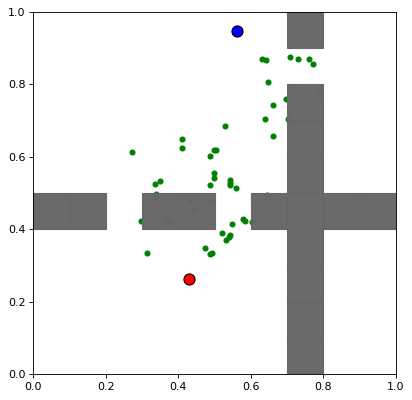

In [60]:
#Show the 10x10 figure formed after application of kernel
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(10):
        for j in range(10):
            if(new_occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=6,
                color = "#676767"
                ))

plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

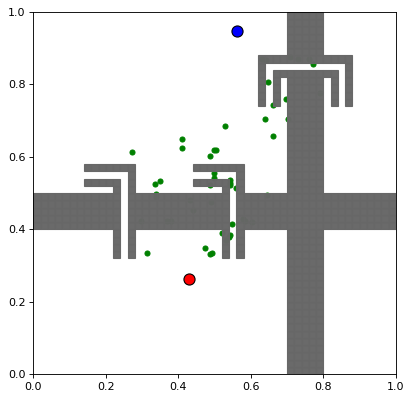

In [61]:
#Show the 50x50 figure 
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(50):
        for j in range(50):
            if(occ_g_50[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/50.0, j/50.0),   # (x,y)
                1/50.0,          # width
                1/50.0,          # height
                alpha=6,
                color = "#676767"
                ))
plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

found path!!


<Figure size 432x288 with 0 Axes>

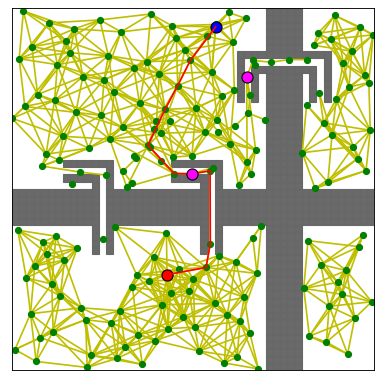

In [62]:
#Run LCS-RRT
planner = LCS_RRT(start=[start[0], start[1]],goal=[goal[0], goal[1]],occ_grid=occ_g_50,rand_area=[0, 1],b_nodes = b_nodes, graph_file="../Sparse_Graph/sparse_graph.graphml",max_iter=10000)
start_time = time.time()
path, dis = planner.planning(animation=True)
end_time = time.time()
if dis is None:
    print("Cannot find path")
    planner.draw_path([])
else:
    print("found path!!")
    planner.draw_path(path)